# Causal Discovery with PCMCI

In [15]:
import os
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages')

# Introduction

In the notebook simulation I covered topics related to particle system and how we can simulate a spring particle system with various trajectories with some underlying causal structure. In this article we will explore how we can use causal reconsturction techniques and conditional independence tests to recover the underlying causal structure for a given trajectory. To reconstruct the causal network from the components time series, we will utilize PC causal discovery algorithm. To accomplish this we will leverage a python package called [Tigramite](https://github.com/jakobrunge/tigramite). Tigramite is a time series analysis module that allows us to reconstruct conditinal indpenence graphical models from discerete or continuous time series based on PCMCI framework.

## 1. Background

Before we can apply the framework for the data gathered in the previous step we need to understand how the framework is working. The framework provides several causal discovery methods that can be used under different sets of assumptions. An application always consists of a method ( PCMCI, PCMCI+, LPCMCI) and a conditional independence test (ParCorr, GPDC, CMIknn, CMIsymb). These conditional independence tests have different set of assumptions. For instance the set of assumptions for ParCorr is univariate, continuous, linear gaussian dependencies. Let's say we have system with 3 variables $X^0$, $X^1$ and $X^2$ and we collected some observations through time for these variables.


| Time | $X^0$ | $X^1$ | $X^2$ | 
| --- | --- | --- | --- | 
| T=0 | -0.6440979 | -1.04341823 | 0.34727786 |
| T=1 | 0.82125751 | -0.18338834 | -1.96378392 | 
| T=2 | 0.65193283 | -0.83690681 | 2.23499787 | 
| T=3 | ... | ... | ... | 
| T=. | ... | ... | ... | 
| T=t-1 | $X^{0}_{t-1}$ | $X^{0}_{t-1}$ | $X^{0}_{t-1}$ | 
| T=t | $X^{0}_{t}$ | $X^{1}_{t}$ | $X^{2}_{t}$ |

We do not know the true process that is generating the data. The PCMCI methods will take this data and conduct a conditional indepedence test to establish underlying causal structure. The algorithm outputs the predicted graph structure with certain probablities. For instance it predicts variable $X^0$ has a causal link with variable $X^1$ from time step t=t-1, $X^0$ from time step t=t-1. We can structurally represent them through these these equations.

\begin{equation*}
X^0_{t} = 0.6 * X^0_{t-1} - 0.8 * X^{1}_{t-1}+\mu^{0}_{t}
\end{equation*}
\begin{equation*}
X^1_{t} = 0.8 * X^1_{t-1} + 0.8 * X^{2}_{t-1}+\mu^{0}_{t}
\end{equation*}
\begin{equation*}
X^2_{t} = 0.2 * X^2_{t-3} - 0.4 * X^{1}_{t-2}+\mu^{1}_{t}
\end{equation*}

We can visulize these strutrucal equations something like this.
Note: I have ignored the noise samples $\mu^{i}_{t}$.

![causal](media/causal.png)

our goal is to reconstruct drivers of each variable.


## 2. Applying PCMCI for a sample data

Before applying PCMCI to the spring particle system lets explore the behaviour of the algorithm for a sample data

== Variables of interest == 
['$X^0$', '$X^1$', '$X^2$', '$X^3$']

== Data ==
[[  0.49671415   1.39935544  -0.67517827  -1.90780756]
 [ -0.1382643    0.92463368  -0.14451867  -0.86038501]
 [  0.64768854   0.05963037  -0.79241992  -0.41360553]
 ...
 [-10.90004356   2.44106964  -3.07908901   0.04227008]
 [ -7.94392568   2.89469444  -2.54888326   2.2267637 ]
 [ -7.54950901   3.26204201  -0.74222854   2.96848306]]

== Time series ==


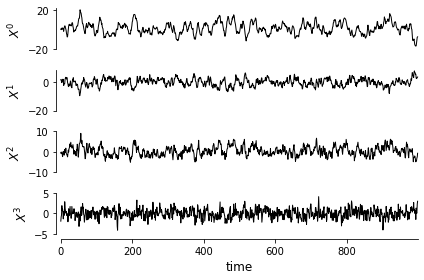

In [16]:
from causality import CausalDiscovery

cd = CausalDiscovery()
data_frame = cd.get_sample_observations()
print("== Variables of interest == ")
print(cd.get_variables())
print("\n== Data ==")
print(data_frame.values)
print("\n== Time series ==")
cd.plot_time_series()

In the above sample data we can see the time series plot for different variables, for a system with these observation through time series lets run the method <b>PCMCI</b> using <b> Partial Correlation </b> as a conditional independence test.

In [17]:
from tigramite.independence_tests import ParCorr
from tigramite.pcmci import PCMCI

pcmci = PCMCI(dataframe=data_frame, cond_ind_test=ParCorr(significance='analytic'), verbosity=1)

results = pcmci.run_pcmci(tau_max=8, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 6 link(s):
    [pc_alpha = 0.2]
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.796
        ($X^1$ -1): max_pval = 0.00000, min_val = -0.748
        ($X^2$ -1): max_pval = 0.05440, min_val = -0.061
        ($X^3$ -2): max_pval = 0.07172, min_val =  0.058
        ($X^3$ -7): max_pval = 0.11314, min_val =  0.051
        ($X^3$ -1): max_pval = 0.19326, min_val = -0.042

    Variable $X^1$ has 3 link(s):
    [pc_alpha = 0.2]
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.695
        ($X^3$ -1): max_pval = 0.00000, min_val =  0.484
        ($X^3$ -7): max_pval = 0.14660, min_val =  0.046

    Variable $X^2$ has 8 link(s):
    [pc_alpha = 0.5]
        ($X^2$ -1): max_pval = 0.00000, min_val =  0.432
        ($X^1

## 2. Applying PCMCI to spring particle system with no causal connection

Before applying the PCMCI techniques to a spring particle system, lets revisit the data from particle system and markdown what variables to model. First we will consider a simple system with just three particles. Let $particle_0$ be causally connected to $particle_2$ and let $particle_1$ be independent of all other particles.

In [18]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from simulations import spring_particle_system

In [19]:
simulation = spring_particle_system.System(num_particles=2, mode='manual')
simulation.set_dynamics(dynamics='static')
simulation.set_static_edges(edges=[[0, 0], [0, 0]])
simulation.set_init_velocity(init_vel=np.asarray([[0.3, 0.00001], [0.4, -0.00001]]))

Lets pick print position, velocity and causality matrix of all particles through time.
causality matrix captures interaction dynamics between all particles and it is represented as $nxn$ matrix where $n$ in number of particles.

In [20]:
trajectory = simulation.sample_trajectory(total_time_steps=5000, sample_freq=10)

# For this simulation sample, lets get all positions
positions = trajectory.positions
velocities = trajectory.velocity
edges = trajectory.edges

# Lets inspect elements at time step 0
time_step = 0

print('------------------------------------------')
print('position of all particles at time step 0')
print('------------------------------------------')
print(positions[time_step], '\n')

print('------------------------------------------')
print('velocity of all particles at time step 0')
print('------------------------------------------')
print(velocities[time_step], '\n')

print('------------------------------------------')
print('causality matrix of all particles at time step 0')
print('------------------------------------------')
print(edges[time_step])

------------------------------------------
position of all particles at time step 0
------------------------------------------
             particle_0  particle_1
x_cordinate   -0.034712    0.606620
y_cordinate   -0.045963   -0.658598 

------------------------------------------
velocity of all particles at time step 0
------------------------------------------
             particle_0  particle_1
x_cordinate         0.3    0.353553
y_cordinate         0.4   -0.353553 

------------------------------------------
causality matrix of all particles at time step 0
------------------------------------------
            particle_0  particle_1
particle_0           0           0
particle_1           0           0


Lets transpose the positions and flatten the data so can capture all variable observation snapshot for a time instance.

In [21]:
time_step = 0
print(positions[time_step].T)
snapshot = np.asarray(positions[time_step].T).flatten()
print(snapshot)

            x_cordinate  y_cordinate
particle_0    -0.034712    -0.045963
particle_1     0.606620    -0.658598
[-0.03471154 -0.04596334  0.60661992 -0.65859778]


Lets construct a data frame for first 20 observations

In [22]:
def get_positions(positions, trajectory_length=100):
    data = []
    for time_step in range(trajectory_length):
        snapshot = np.asarray(positions[time_step].T).flatten()
        data.append(np.asarray(snapshot))
    data = np.asarray(data)
    return data

positions = get_positions(positions, trajectory_length=500)

== Variables of interest == 
['$X^0$', '$X^1$', '$X^2$', '$X^3$']

== Data ==
[[-0.03471154 -0.04596334  0.60661992 -0.65859778]
 [-0.03171154 -0.04196334  0.61015545 -0.66213331]
 [-0.02871154 -0.03796334  0.61369099 -0.66566885]
 ...
 [ 1.45628846  1.94203666  2.36378027 -2.41575813]
 [ 1.45928846  1.94603666  2.3673158  -2.41929366]
 [ 1.46228846  1.95003666  2.37085134 -2.4228292 ]]

== Time series ==


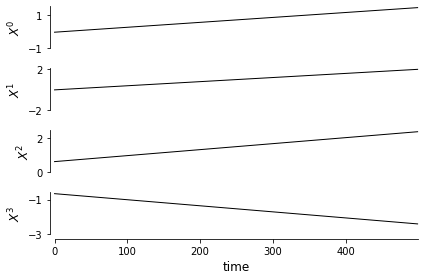

In [27]:
cd = CausalDiscovery()
cd.set_num_of_variables(2*2)
data_frame = cd.set_data(positions)
print("== Variables of interest == ")
print(cd.get_variables())
print("\n== Data ==")
print(data_frame.values)
print("\n== Time series ==")
cd.plot_time_series()

We notice for a system with $n$ particles we have $2*n$ variables and that is because we are treating each particle and associated dimensional components as a variable.

$X^0$ -> Particle 0 x co-ordinate
$X^1$ -> Particle 0 y co-ordinate
$X^2$ -> Particle 1 x co-ordinate
$X^2$ -> Particle 2 y co ordinate

| Variable | attribute | 
| --- | --- |
| $X^0$ | Particle 0 x co-ordinate |
| $X^1$ | Particle 0 y co-ordinate |
| $X^2$ | Particle 1 x co-ordinate |
| $X^3$ | Particle 1 y co-ordinate |
| $X^4$ | Particle 2 x co-ordinate |
| $X^5$ | Particle 2 xy co-ordinate |


In the autocorrelation plot we can also confirm that the correlation drops as we move back in time and roughly around the time where the causality changes we see changes in the autocorrelation.

------- pearson correlation -------
     t-1  t+1
t-1  NaN  NaN
t+1  NaN  NaN
-----------------------------------


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:453: RuntimeWarning: invalid value encountered in double_scalars
  return ((data[: n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

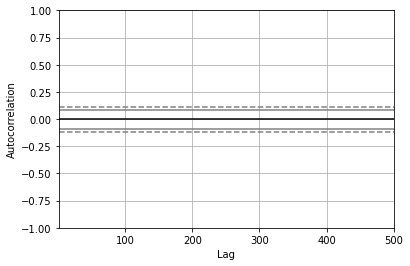

In [28]:
total_energy = []
time_step = 0
for position in trajectory.total_energy:
    for particle_id in position.columns:
        total_energy.append({
            'total_energy': position[particle_id]['total_energy'],
            'particle': particle_id,
            'time_step': time_step
        })
    time_step += 1
energy_dframe = pd.DataFrame(total_energy)

pos = energy_dframe.set_index('time_step')
edf = pos[pos.particle=='particle_0'].total_energy
_df = pd.concat([edf.shift(1), edf], axis=1)
_df.columns = ['t-1', 't+1']
result = _df.corr()
print("------- pearson correlation -------")
print(result)
print("-----------------------------------")

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(edf)

### 2.1 Running PCMCI
Now that we have defined the variables lets run the test and see the results.

In [29]:
pcmci = PCMCI(dataframe=data_frame, cond_ind_test=ParCorr(significance='analytic'), verbosity=1)
results = pcmci.run_pcmci(tau_max=5, pc_alpha=None)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 19 link(s):
    [pc_alpha = 0.05]
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.792
        ($X^0$ -5): max_pval = 0.00000, min_val = -0.626
        ($X^0$ -4): max_pval = 0.00000, min_val = -0.512
        ($X^1$ -4): max_pval = 0.00000, min_val =  0.466
        ($X^1$ -5): max_pval = 0.00000, min_val =  0.464
        ($X^1$ -3): max_pval = 0.00000, min_val =  0.438
        ($X^1$ -2): max_pval = 0.00000, min_val =  0.412
        ($X^1$ -1): max_pval = 0.00000, min_val =  0.385
        ($X^2$ -5): max_pval = 0.00000, min_val =  0.355
        ($X^2$ -3): max_pval = 0.00000, min_val =  0.354
        ($X^2$ -4): max_pval = 0.00000, min_val =  0.354
        ($X^2$ -2): max_pval = 0.00000, min_val =  0.353
        (

### 2.2 Intrepreting results

If we can look at the PC1 algorithm with lagged conditions results. We can see that variable $X^2$ and $X^3$ only dependents on its past values and we can explain it through $particle 2$'s initial velocity. $particle 2$ has no causal link with any other particles and thus we dont see and references to other particles in the results. $particle 0$ and $particle 1$ are causally linked and thus we can see those causal connections in the results.

### 2.3 Simplified model

Lets further simplify our model to set initial velocity to $0.0$ for $particle 2$ and run the tests. We should see $particle 2$ independent of its past values since its both x and y co ordinates are static. We can generate data set by setting these values.

Now visit back to section 1.1 and reload the data and run the tests again. This time you will notice variable $X^2$ is causally connected with variable $X^3$ because for the observed sampled there is a high co rellation of 1. We can run the expreriment again by setting different initial velocity for different dimensions.

In [30]:
print(results['p_matrix'].round(1))

[[[1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0.]]]


In [32]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], 
                                       tau_max=5, 
                                       fdr_method='fdr_bh')
pcmci.print_significant_links(p_matrix=results['p_matrix'], 
                              q_matrix=q_matrix, 
                              val_matrix=results['val_matrix'], 
                              alpha_level=0.01)

link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix, 
                                             val_matrix=results['val_matrix'], 
                                             alpha_level=0.01)['link_matrix']


## Significant links at alpha = 0.01:

    Variable $X^0$ has 23 link(s):
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val =  1.000
        ($X^0$ -2): pval = 0.00000 | qval = 0.00000 | val =  1.000
        ($X^0$ -3): pval = 0.00000 | qval = 0.00000 | val =  1.000
        ($X^0$ -4): pval = 0.00000 | qval = 0.00000 | val =  1.000
        ($X^0$ -5): pval = 0.00000 | qval = 0.00000 | val =  1.000
        ($X^3$ -5): pval = 0.00000 | qval = 0.00000 | val =  0.984
        ($X^3$ -4): pval = 0.00000 | qval = 0.00000 | val =  0.982
        ($X^3$ -3): pval = 0.00000 | qval = 0.00000 | val =  0.981
        ($X^2$  0): pval = 0.00000 | qval = 0.00000 | val = -0.979
        ($X^3$ -2): pval = 0.00000 | qval = 0.00000 | val =  0.979
        ($X^3$  0): pval = 0.00000 | qval = 0.00000 | val =  0.979
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.978
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val = -0.974
        ($X^1$ -5): pval = 0.00000 | qval = 0.00000 | 

(<Figure size 432x288 with 3 Axes>, <AxesSubplot:>)

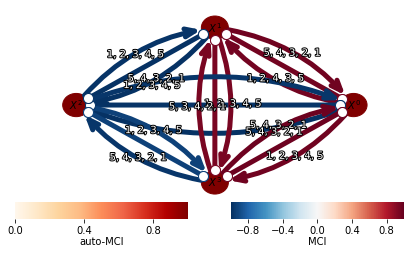

In [34]:
from tigramite import plotting as tp
variable_names = cd.get_variables()
tp.plot_graph(val_matrix=results['val_matrix'], link_matrix=link_matrix, var_names=variable_names)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

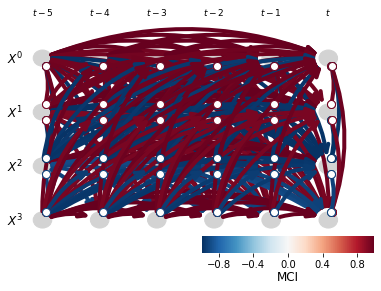

In [35]:
tp.plot_time_series_graph(figsize=(6, 4), 
                          val_matrix=results['val_matrix'], 
                          link_matrix=link_matrix, 
                          var_names=variable_names, 
                          link_colorbar_label='MCI')

## 2. Applying PCMCI to spring particle system with connection

In the previous section we have set edges explicty as zeros to mimic a non causal system. In this section lets establish causal links between these particles and see the response.

== Variables of interest == 
['$X^0$', '$X^1$', '$X^2$', '$X^3$']

== Data ==
[[ 0.50222523  0.36824175  0.62166874  0.14583623]
 [ 0.50522582  0.37224064  0.62520368  0.14230181]
 [ 0.50822749  0.37623746  0.62873754  0.13876945]
 ...
 [ 2.16242599  1.07818636  2.20962833 -0.33326874]
 [ 2.16604871  1.07607709  2.21254114 -0.330695  ]
 [ 2.16967185  1.07395516  2.21545353 -0.3281086 ]]

== Time series ==

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 10 link(s):
    [pc_alpha = 0.05]
        ($X^0$ -1): max_pval = 0.00000, min_val =  0.555
        ($X^3$ -5): max_pval = 0.00000, min_val = -0.251
        ($X^2$ -4): max_pval = 0.00000, min_val =  0.221
        ($X^1$ -1): max_pval = 0.00056, min_val = -0.157
        ($X^2$ -2): max_pval = 0.00201, min_val = -0.140

(<Figure size 432x288 with 3 Axes>, <AxesSubplot:>)

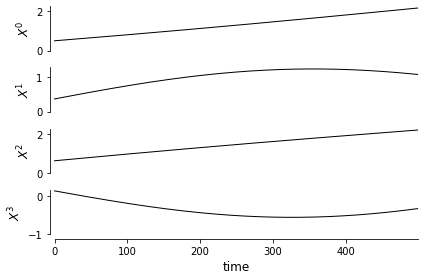

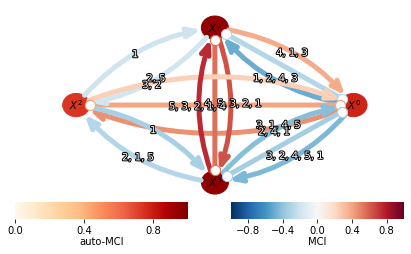

In [36]:
simulation = spring_particle_system.System(num_particles=2, mode='manual')
simulation.set_dynamics(dynamics='static')
simulation.set_static_edges(edges=[[0, 0.9], [0.9, 0]])
simulation.set_init_velocity(init_vel=np.asarray([[0.3, 0.00001], [0.4, -0.00001]]))

trajectory = simulation.sample_trajectory(total_time_steps=5000, sample_freq=10)

# For this simulation sample, lets get all positions
positions = trajectory.positions
velocities = trajectory.velocity
edges = trajectory.edges

def get_positions(positions, trajectory_length=100):
    data = []
    for time_step in range(trajectory_length):
        snapshot = np.asarray(positions[time_step].T).flatten()
        data.append(np.asarray(snapshot))
    data = np.asarray(data)
    return data

positions = get_positions(positions, trajectory_length=500)


cd = CausalDiscovery()
cd.set_num_of_variables(2*2)
data_frame = cd.set_data(positions)
print("== Variables of interest == ")
print(cd.get_variables())
print("\n== Data ==")
print(data_frame.values)
print("\n== Time series ==")
cd.plot_time_series()

pcmci = PCMCI(dataframe=data_frame, cond_ind_test=ParCorr(significance='analytic'), verbosity=1)
results = pcmci.run_pcmci(tau_max=5, pc_alpha=None)

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], 
                                       tau_max=5, 
                                       fdr_method='fdr_bh')
pcmci.print_significant_links(p_matrix=results['p_matrix'], 
                              q_matrix=q_matrix, 
                              val_matrix=results['val_matrix'], 
                              alpha_level=0.01)

link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix, 
                                             val_matrix=results['val_matrix'], 
                                             alpha_level=0.01)['link_matrix']

tp.plot_graph(val_matrix=results['val_matrix'], link_matrix=link_matrix, var_names=variable_names)

## Conclusion

<b>I still dont know what is going on here</b>, but I am running few more expriements to understand how data, tests and methods are inter related.